In [1]:
%cd ..

/Users/jorgensandhaug/Documents/github_documents/option_pricing_framework


In [27]:
from simulations.heston_process import HestonProcess


simulation_params={
   "kappa": 3,
   "theta": 0.2**2,
   "initial_variance": 0.25**2,
   "rho": -0.97,
   "volvol": 0.6,
   "time_steps": 252,
   "simulation_paths": 1000,
   "risk_free_rate": 0.02,
   "time_to_maturity": 1,
   "initial_stock_price": 100,
}


simulator = HestonProcess(simulation_params=simulation_params)
prices = simulator.simulate()



In [28]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

num_paths = 100
# Add traces for each simulation path
for i in range(num_paths):
    fig.add_trace(go.Scatter(
        x=list(range(prices.shape[1])),
        y=prices[i],
        mode='lines',
        line=dict(width=1),
        opacity=0.5
    ))

# Update layout for a clean and visually stunning look
fig.update_layout(
    title='Heston Model Price Paths',
    xaxis_title='Time Steps',
    yaxis_title='Stock Price',
    template='plotly_dark',
    showlegend=False,
    margin=dict(l=0, r=0, t=30, b=0)
)

# Show the plot
fig.show()

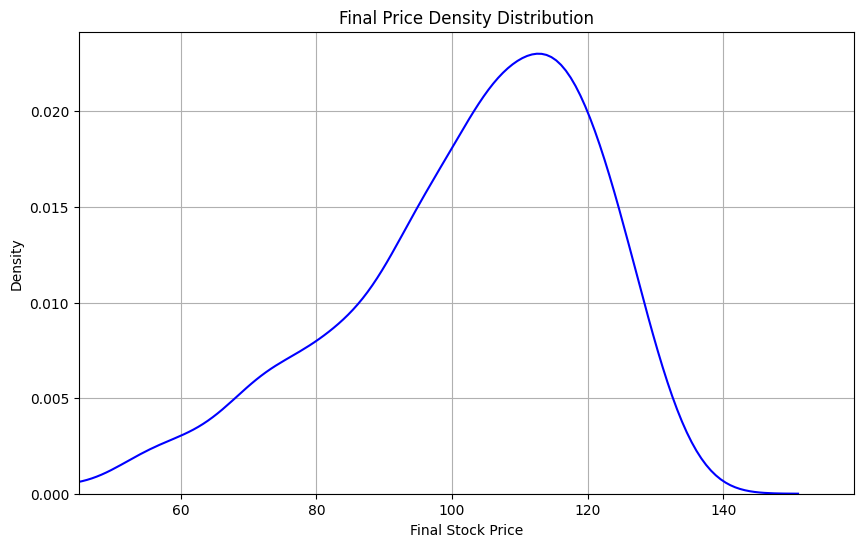

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plot the final price density distribution using seaborn's kdeplot
final_prices = prices[:, -1]
mean_price = np.mean(final_prices)
std_price = np.std(final_prices)

plt.figure(figsize=(10, 6))
sns.kdeplot(final_prices, fill=False, color='blue')
plt.title('Final Price Density Distribution')
plt.xlabel('Final Stock Price')
plt.ylabel('Density')
plt.grid(True)

# Set x-axis limits to focus on the center of the distribution
plt.xlim(mean_price - 3*std_price, mean_price + 3*std_price)

plt.show()

In [30]:
from utils.option_utils import OptionUtils
from models.european.european_option_simulation import EuropeanOptionSimulationModel
from simulations.geometric_brownian_motion import GeometricBrownianMotion

pricing_params = {
    "initial_stock_price": 100,
    "strike_price": 100,
    "time_to_maturity": 1,
    "risk_free_rate": 0.05,
    "option_type": "call",
}

simulation_params={
   "theta": 0.1,
   "initial_variance": 0.1,
   "kappa": 1,
   "rho": -0.2,
   "volvol": 5,
   "time_to_maturity": 1,
   "time_steps": 1000,
   "simulation_paths": 10000,
   "risk_free_rate": 0.05,
   "initial_stock_price": 100,
   "volatility": 0.5,
}

strikes = [70+2*i for i in range(30)]

simulator = HestonProcess(simulation_params)
# simulator = GeometricBrownianMotion(simulation_params)
pricer = EuropeanOptionSimulationModel(None)
prices = simulator.simulate()

implied_vols = []
prices_at_strike = []

for strike in strikes:
    pricing_params["strike_price"] = strike
    price = pricer.price(pricing_params, simulated_prices=prices)
    
    prices_at_strike.append(price)

    implied_vol, _, did_converge = OptionUtils.find_implied_volatility(pricing_params, market_price=price)
    
 
    if not did_converge:
        print(f"Failed to converge for strike {strike}, got {implied_vol}")
        implied_vol = None

    implied_vols.append(implied_vol)



In [31]:
# Plotting the prices at strike and implied volatilities
fig = go.Figure()

# Add trace for prices at strike
fig.add_trace(go.Scatter(
    x=strikes,
    y=prices_at_strike,
    mode='lines+markers',
    name='Prices at Strike',
    line=dict(width=2),
    marker=dict(size=5)
))

# Add trace for implied volatilities with secondary y-axis
fig.add_trace(go.Scatter(
    x=strikes,
    y=implied_vols,
    mode='lines+markers',
    name='Implied Volatility',
    line=dict(width=2),
    marker=dict(size=5),
    yaxis='y2'
))

fig.update_layout(
    title='Prices at Strike and Implied Volatility vs Strike Price',
    xaxis_title='Strike Price',
    yaxis=dict(
        title='Prices at Strike',
    ),
    yaxis2=dict(
        title='Implied Volatility',
        overlaying='y',
        side='right'
    ),
    template='plotly_dark'
)

fig.show()